In [3]:
from pathlib import Path

from cities.utils.data_grabber import DataGrabber
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import pickle
import os
import sys


current_dir =  os.getcwd()

grandparent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, grandparent_dir)

In [4]:
data = DataGrabber()
data.get_features_wide(["gdp", "population", "spending_HHS", "ethnic_composition"])
gdp = data.wide
gdp = gdp.get("gdp")


population= data.wide
population = population.get("population")

spending_HHS= data.wide
spending_HHS = spending_HHS.get("spending_HHS")


ethnic_composition= data.wide
ethnic_composition = ethnic_composition.get("ethnic_composition")

In [22]:
def standardize_and_scale(data: pd.DataFrame, variable_name: str, standard_function: str = 'sigmoid') -> pd.DataFrame:
  
    transformation_info_dict_path = f"{grandparent_dir}/data/raw/std_info.pkl"
    if os.path.exists(transformation_info_dict_path):
        with open(transformation_info_dict_path, "rb") as file:
            transformation_info_dict = pickle.load(file)
    else:
        transformation_info_dict = {}
    
    standard_scaler = StandardScaler()  # Standardize to mean 0, std 1

    def sigmoid(x, scale=1 / 4):
        return 2 / (1 + np.exp(-x * scale)) - 1
    
    def tanh(x):
        return np.tanh(x)

    if standard_function == "sigmoid":
        standard_function = sigmoid
    elif standard_function == "tanh":
        standard_function = tanh
    else:
        raise ValueError("standard_function must be either 'sigmoid' or 'tanh'")

    new_data = data.copy()


    float_cols = data.select_dtypes(include=["float64"])


    transformation_info = {}

    for column in float_cols.columns:
        # Get mean and std for each column
        mean_value = float_cols[column].mean()
        std_value = float_cols[column].std()

        # Save information in the dictionary
        transformation_info[column] = {"mean": mean_value, "std": std_value}

        # Standardize float columns to mean 0, std 1
        standardized_values = standard_scaler.fit_transform(float_cols[[column]])

        # Apply sigmoid transformation, [-3std, 3std] to [-1, 1]
        new_data[column] = standard_function(standardized_values) # if sigmoid the defeault scale is used

    # Update the global transformation_info_dict
    transformation_info_dict[variable_name] = transformation_info

    with open(f"{grandparent_dir}/data/raw/std_info.pkl", "wb") as file:
        pickle.dump(transformation_info_dict, file)


    return new_data


def revert_standardize_and_scale(data: pd.DataFrame, variable_name: str,  standard_function: str = 'sigmoid') -> pd.DataFrame:
    """
    Inverts the standardization and scaling operation using the provided transformation information from a file.
    Returns the original DataFrame.
    """
    def inverse_sigmoid(y, scale=1 / 4):
        return -np.log((2 / (y + 1)) - 1) / scale
    

    def inverse_tanh(y):
        epsilon = 1e-15  # Set a small epsilon value to avoid issues with precision
        if -1 + epsilon < y < 1 - epsilon:
            return np.arctanh(y)
        elif y <= -1 + epsilon:
            return -np.inf
        elif y >= 1 - epsilon:
            return np.inf
    
    if standard_function == "sigmoid":
        standard_function = inverse_sigmoid
    elif standard_function == "tanh":
        standard_function = inverse_tanh
    else:
        raise ValueError("standard_function must be either 'sigmoid' or 'tanh'")


    inverted_data = data.copy()


    file_path = f"{grandparent_dir}/data/raw/std_info.pkl"
    with open(file_path, "rb") as file:
        transformation_info_dict = pickle.load(file)

    transformation_info = transformation_info_dict.get(variable_name, {})

    

    for column, info in transformation_info.items():

        inverted_values = standard_function(data[column])


        inverted_values = inverted_values * info["std"] + info["mean"]

        # mitigating the influence of negative values
        inverted_values[inverted_values < 0] = inverted_values * -0.0000001

        inverted_data[column] = inverted_values

    return inverted_data

In [138]:
# sinh, version that works for gdp like variables:

def transform_to_sinh(data: pd.DataFrame) -> pd.DataFrame:
    transformed_data = data.copy()

    float_cols = data.select_dtypes(include=["float64"])

    for column in float_cols.columns:
        transformed_data[column] = np.sinh(float_cols[column])

    return transformed_data


def reverse_transform_from_sinh(data: pd.DataFrame) -> pd.DataFrame:
    inverted_data = data.copy()

    float_cols = data.select_dtypes(include=["float64"])

    for column in float_cols.columns:
        # Reverse the sinh transformation using the inverse hyperbolic sine function
        inverted_data[column] = np.arcsinh(data[column])

    return inverted_data


# sinh, version that works for spending_HHS like variables:


# def transform_to_sinh(data: pd.DataFrame) -> pd.DataFrame:
#     transformed_data = data.copy()

#     float_cols = data.select_dtypes(include=["float64"])

#     for column in float_cols.columns:
#         # Identify values that might cause overflow
#         overflow_mask = abs(float_cols[column]) > np.log(np.finfo(np.float64).max)

#         # Apply hyperbolic sine transformation without threshold for values not causing overflow
#         transformed_data[column] = np.where(
#             overflow_mask,
#             np.sign(float_cols[column]) * np.log1p(np.abs(float_cols[column])),
#             np.sinh(float_cols[column])
#         )

#     return transformed_data


# def reverse_transform_from_sinh(data: pd.DataFrame, threshold=1e-5) -> pd.DataFrame:
#     inverted_data = data.copy()

#     float_cols = data.select_dtypes(include=["float64"])

#     for column in float_cols.columns:
#         # Identify values that were transformed using the logarithmic transformation
#         log_transformed_mask = abs(data[column]) > np.log1p(threshold)

#         # Reverse the sinh transformation using the inverse hyperbolic sine function
#         inverted_data[column] = np.where(
#             log_transformed_mask,
#             np.sign(data[column]) * np.expm1(data[column]),
#             np.arcsinh(data[column])
#         )

#     return inverted_data


In [132]:
gdp



,GeoFIPS,GeoName,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",59.839,61.996,63.508,73.730,75.307,80.459,81.836,73.870,...,86.679,93.060,93.155,99.931,104.090,99.798,100.854,97.233,96.115,94.638
1,1003,"Baldwin, AL",73.853,77.273,81.570,90.523,101.402,104.553,107.840,102.635,...,99.000,104.651,106.431,110.434,115.476,118.498,125.068,131.431,131.614,144.294
2,1005,"Barbour, AL",113.864,111.853,114.628,124.473,125.004,122.611,118.397,110.695,...,103.918,113.335,106.760,103.702,101.969,100.509,101.804,102.053,98.044,99.393
3,1007,"Bibb, AL",80.443,81.527,85.124,89.317,88.782,89.597,95.308,94.745,...,102.559,99.537,97.933,94.594,95.812,96.878,96.988,104.620,109.487,107.878
4,1009,"Blount, AL",92.104,92.593,95.469,98.129,100.918,97.428,96.720,97.077,...,91.938,99.318,101.584,106.506,98.394,104.331,109.560,106.565,100.422,113.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,56037,"Sweetwater, WY",92.340,81.094,83.237,84.315,89.539,103.241,109.911,112.520,...,103.317,99.506,96.656,93.916,91.543,89.449,86.267,88.195,80.164,74.912
3070,56039,"Teton, WY",81.931,84.886,85.316,86.359,88.884,96.508,98.646,97.627,...,95.810,102.194,110.461,112.837,114.846,119.415,121.268,123.476,125.412,155.522
3071,56041,"Uinta, WY",99.906,110.550,107.053,108.929,112.808,123.552,126.916,127.784,...,106.181,96.674,94.344,95.302,94.681,93.024,89.431,86.759,77.512,76.147
3072,56043,"Washakie, WY",92.187,91.281,95.083,95.411,91.317,102.153,95.987,106.530,...,107.934,101.335,104.043,106.056,94.451,89.130,89.160,92.316,91.539,92.003


In [139]:
gdp_stand = transform_to_sinh(gdp)

gdp_restored = reverse_transform_from_sinh(gdp_stand)

gdp_restored

/home/nikodem/.pyenv/versions/3.12.0/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


,GeoFIPS,GeoName,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",59.839,61.996,63.508,73.730,75.307,80.459,81.836,73.870,...,86.679,93.060,93.155,99.931,104.090,99.798,100.854,97.233,96.115,94.638
1,1003,"Baldwin, AL",73.853,77.273,81.570,90.523,101.402,104.553,107.840,102.635,...,99.000,104.651,106.431,110.434,115.476,118.498,125.068,131.431,131.614,144.294
2,1005,"Barbour, AL",113.864,111.853,114.628,124.473,125.004,122.611,118.397,110.695,...,103.918,113.335,106.760,103.702,101.969,100.509,101.804,102.053,98.044,99.393
3,1007,"Bibb, AL",80.443,81.527,85.124,89.317,88.782,89.597,95.308,94.745,...,102.559,99.537,97.933,94.594,95.812,96.878,96.988,104.620,109.487,107.878
4,1009,"Blount, AL",92.104,92.593,95.469,98.129,100.918,97.428,96.720,97.077,...,91.938,99.318,101.584,106.506,98.394,104.331,109.560,106.565,100.422,113.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,56037,"Sweetwater, WY",92.340,81.094,83.237,84.315,89.539,103.241,109.911,112.520,...,103.317,99.506,96.656,93.916,91.543,89.449,86.267,88.195,80.164,74.912
3070,56039,"Teton, WY",81.931,84.886,85.316,86.359,88.884,96.508,98.646,97.627,...,95.810,102.194,110.461,112.837,114.846,119.415,121.268,123.476,125.412,155.522
3071,56041,"Uinta, WY",99.906,110.550,107.053,108.929,112.808,123.552,126.916,127.784,...,106.181,96.674,94.344,95.302,94.681,93.024,89.431,86.759,77.512,76.147
3072,56043,"Washakie, WY",92.187,91.281,95.083,95.411,91.317,102.153,95.987,106.530,...,107.934,101.335,104.043,106.056,94.451,89.130,89.160,92.316,91.539,92.003


In [37]:
def compare_restored_data(data_oryg: pd.DataFrame, data_restored: pd.DataFrame) -> None:
    

    oryg_values = data_oryg.select_dtypes(include=["float64"]).values.flatten()
    restored_values = data_restored.select_dtypes(include=["float64"]).values.flatten()



    differences = abs(oryg_values - restored_values)


    df = pd.DataFrame({'original': oryg_values, 'diff': differences})

   
    df['percentages'] = (df['diff'] / (df['original'] + 0.1)) * 100

    df = df.sort_values(by='original', ascending=True)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot for Percentage Difference
    ax1.plot(df['original'], df['percentages'], marker='o', linestyle='-')
    ax1.set_title('Percentage Difference')
    ax1.set_xlabel('Index (ordered ascending)')
    ax1.set_ylabel('Percentage Difference')

    # Plot for Absolute Difference
    ax2.plot(df['original'], df['diff'], marker='o', linestyle='-', color='orange')
    ax2.set_title('Absolute Difference')
    ax2.set_xlabel('Index (ordered ascending)')
    ax2.set_ylabel('Absolute Difference')

    total_rows = df.shape[0]
    first_05_percent = df.head(int(0.05 * total_rows))
    last_95_percent = df.tail(int(0.95 * total_rows))

    mean_first_5_percent = round(first_05_percent['percentages'].mean(), 4)
    mean_last_95_percent = round(last_95_percent['percentages'].mean(), 4)

    print(f"Mean Percentage of First 5%: {mean_first_5_percent}")
    print(f"Mean Percentage of Last 95%: {mean_last_95_percent}")

    plt.tight_layout()
    plt.show()


Mean Percentage of First 5%: 0.0
Mean Percentage of Last 95%: inf


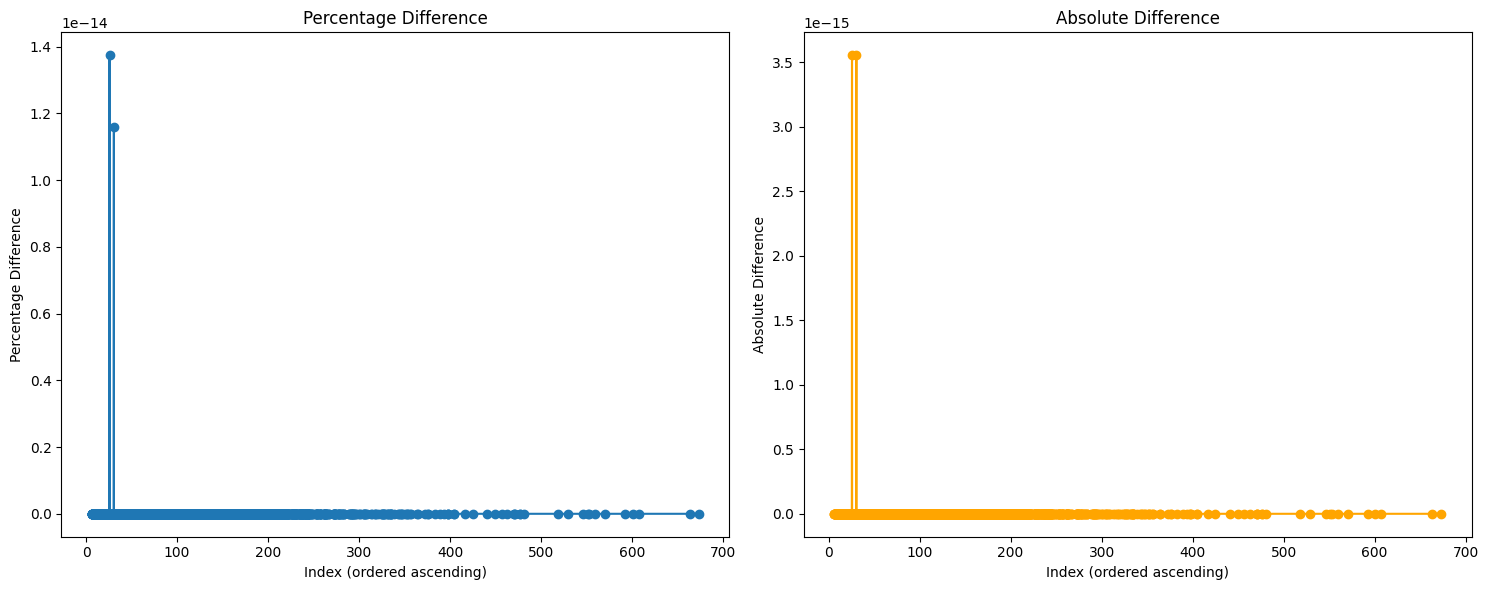

In [38]:
compare_restored_data(gdp, gdp_restored)

/home/nikodem/.pyenv/versions/3.12.0/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mean Percentage of First 5%: inf
Mean Percentage of Last 95%: inf


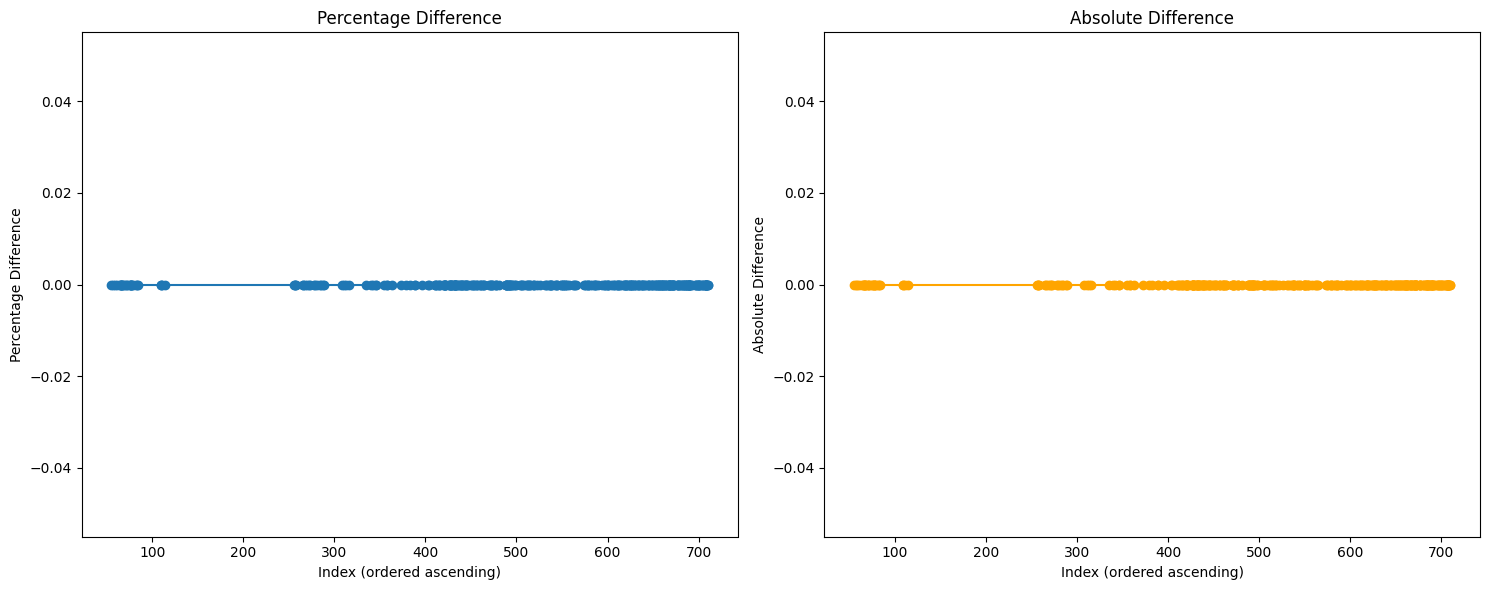

In [40]:
population_stand = transform_to_sinh(population)
population_restored = reverse_transform_from_sinh(population_stand)
compare_restored_data(population, population_restored)

In [49]:
spending_HHS

,GeoFIPS,GeoName,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1003,"Baldwin, AL",49158971.0,23130080.0,23130080.0,23130080.00,36440297.60,18472412.30,35286407.60,5.226931e+07,5.233552e+07,6.820575e+07,2.908341e+07,1.472459e+07
2,1005,"Barbour, AL",0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1007,"Bibb, AL",0.0,0.0,13161891.0,66916266.00,66916266.00,87212508.00,87785697.00,1.102956e+08,2.311282e+08,3.560715e+08,3.956040e+08,3.497175e+08
4,1009,"Blount, AL",0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.236365e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,56037,"Sweetwater, WY",9662044.0,4831022.0,9662044.0,6629889.66,11093915.66,15557941.66,26585707.98,2.422140e+07,1.340291e+07,2.680582e+07,2.680582e+07,2.710532e+07
3070,56039,"Teton, WY",11378574.0,5689287.0,5689287.0,5689287.00,17067861.00,4765628.00,14296884.00,1.457931e+07,1.906251e+07,2.382814e+07,3.070260e+07,1.146478e+07
3071,56041,"Uinta, WY",6249070.0,6054374.0,6054374.0,3565639.00,3565639.00,12921095.00,29407829.00,2.005237e+07,3.432017e+07,4.345827e+07,5.672066e+07,4.280595e+07
3072,56043,"Washakie, WY",64307789.0,46573884.0,28839979.0,43868878.00,21186675.00,23016679.00,60935019.00,5.552501e+07,1.010162e+08,1.494539e+08,1.629841e+08,1.116085e+08


In [134]:
spending_HHS_stand = transform_to_sinh(spending_HHS)
spending_HHS_restored = reverse_transform_from_sinh(spending_HHS_stand)
#compare_restored_data(spending_HHS, spending_HHS_restored)

spending_HHS_restored

/home/nikodem/.pyenv/versions/3.12.0/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


,GeoFIPS,GeoName,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1003,"Baldwin, AL",17.710570,16.956645,16.956645,16.956645,17.411186,16.731789,17.379008,17.771920,17.773186,18.038039,17.185679,16.505029
2,1005,"Barbour, AL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1007,"Bibb, AL",0.000000,0.000000,16.392836,18.018953,18.018953,18.283858,18.290409,18.518674,19.258483,19.690642,19.795924,19.672636
4,1009,"Blount, AL",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.725109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,56037,"Sweetwater, WY",16.083716,15.390569,16.083716,15.707099,16.221907,16.560082,17.095884,17.002747,16.410983,17.104130,17.104130,17.115241
3070,56039,"Teton, WY",16.247243,15.554096,15.554096,15.554096,16.652708,15.376940,16.475552,16.495114,16.763234,16.986378,17.239858,16.254791
3071,56041,"Uinta, WY",15.647943,15.616292,15.616292,15.086854,15.086854,16.374372,17.196772,16.813858,17.351244,17.587312,17.853649,17.572188
3072,56043,"Washakie, WY",17.979191,17.656551,17.177273,17.596716,16.868883,16.951730,17.925319,17.832344,18.430792,18.822499,18.909163,18.530508


In [122]:
spending_HHS

,GeoFIPS,GeoName,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1003,"Baldwin, AL",49158971.0,23130080.0,23130080.0,23130080.00,36440297.60,18472412.30,35286407.60,5.226931e+07,5.233552e+07,6.820575e+07,2.908341e+07,1.472459e+07
2,1005,"Barbour, AL",0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1007,"Bibb, AL",0.0,0.0,13161891.0,66916266.00,66916266.00,87212508.00,87785697.00,1.102956e+08,2.311282e+08,3.560715e+08,3.956040e+08,3.497175e+08
4,1009,"Blount, AL",0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.236365e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,56037,"Sweetwater, WY",9662044.0,4831022.0,9662044.0,6629889.66,11093915.66,15557941.66,26585707.98,2.422140e+07,1.340291e+07,2.680582e+07,2.680582e+07,2.710532e+07
3070,56039,"Teton, WY",11378574.0,5689287.0,5689287.0,5689287.00,17067861.00,4765628.00,14296884.00,1.457931e+07,1.906251e+07,2.382814e+07,3.070260e+07,1.146478e+07
3071,56041,"Uinta, WY",6249070.0,6054374.0,6054374.0,3565639.00,3565639.00,12921095.00,29407829.00,2.005237e+07,3.432017e+07,4.345827e+07,5.672066e+07,4.280595e+07
3072,56043,"Washakie, WY",64307789.0,46573884.0,28839979.0,43868878.00,21186675.00,23016679.00,60935019.00,5.552501e+07,1.010162e+08,1.494539e+08,1.629841e+08,1.116085e+08


In [61]:
1.000005e-05

1.000005e-05

Mean Percentage of First 5%: 0.0
Mean Percentage of Last 95%: 0.0018


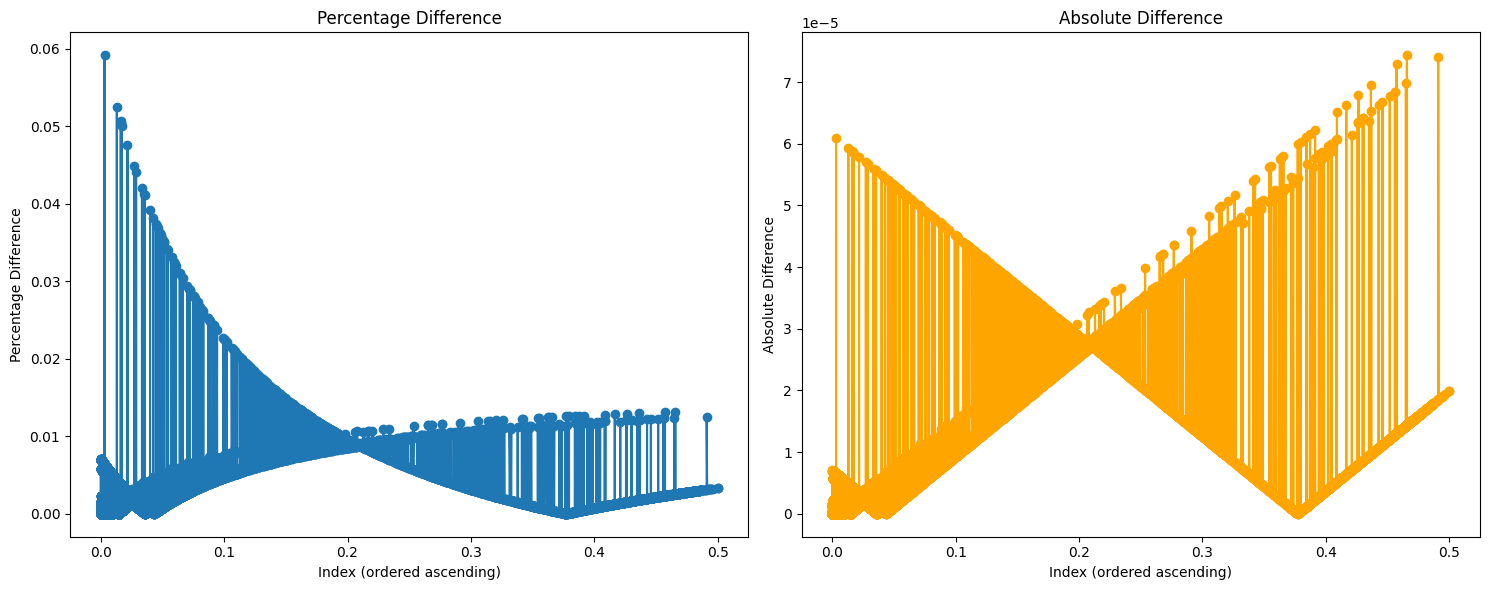

In [50]:
ethnic_composition_stand = standardize_and_scale(ethnic_composition, "ethnic_composition")
ethnic_composition_restored = revert_standardize_and_scale(ethnic_composition_stand, "ethnic_composition")
compare_restored_data(ethnic_composition, ethnic_composition_restored)

In [65]:
with open(f"{grandparent_dir}/data/raw/std_info.pkl", "rb") as file:
    loaded_data = pickle.load(file)

loaded_data.keys()

dict_keys(['spending_HHS', 'gdp', 'population', 'ethnic_composition'])